In [10]:
!pip install inflect feather symspellpy
!pip install --upgrade pandas==2.0.3
!pip install contractions
!{sys.executable} -m pip install contractions

  Obtaining dependency information for inflect from https://files.pythonhosted.org/packages/fb/c6/d9feb758be584f729424390af24687d3a4363d968164f94079f83cd536b4/inflect-7.0.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 588.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 24.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [15]:
!pip install symspellpy

  Using cached symspellpy-6.7.7-py3-none-any.whl (2.6 MB)
  Using cached editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl


In [16]:
# Import the libraries
import sys
import string
import pandas as pd
import string
import contractions
#import feather
import inflect
import pkg_resources
from symspellpy import SymSpell, Verbosity
import re
import html
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
data = {'txt':["i don't want to","this ain't what i said"]}
df = pd.DataFrame(data)

In [33]:
# Load the dataset
df = pd.read_csv('/kaggle/input/reddit-depression-spellchecked/reddit_clf_corrected_latest.csv')

In [3]:
pd.set_option("display.max_columns", None)

In [34]:
df.head()

,Unnamed: 0,text,class,prep_txt
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i dont get affected by compliments ...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally two thousand and twenty is almost over...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i’m so losthello my name is adam sixteen and i...


## Pre-Processing

In [35]:
df.columns

Index(['Unnamed: 0', 'text', 'class', 'prep_txt'], dtype='object')

In [36]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [37]:
# Remove html special characters
df['text'] = df['text'].apply(lambda x: html.unescape(x) if pd.notnull(x) else x)

In [38]:
# remove punctuation
def remove_punct(text):
    text = str(text)
    txt_nopunct = "".join([char for char in text if char not in string.punctuation])
    return txt_nopunct

df['prep_txt'] = df['text'].apply(lambda x: remove_punct(x))

In [39]:
def expand_contraction(text):
    return ' '.join([contractions.fix(word) for word in text.split()])
df['prep_txt'] = df['prep_txt'].apply(lambda x: expand_contraction(x))

In [40]:
# custom dictionary
custom_dict = {
    'GF':'girlfriend',
    'BF':'boyfriend',
    'bf':'boyfriend',
    'gf':'girlfriend',
    '15,':'fifteen',
    '(21)':'twenty one',
    'hes':'he is',
    '&': 'and',
    'a&e':'accident and emergency',
    'orr': 'or',
    'rn' : 'right now',
    'ppl': 'people',
    'irl': 'In real life'
}

In [41]:
df['prep_txt'] = df.prep_txt.str.replace('[...…]','').str.split().apply(lambda x: ' '.join([custom_dict.get(e, e) for e in x]))

In [42]:
list1 = ['M','F','%','+']
list2 = [' Male',' Female',' percent',' plus']

def convert(string):

	word_list = string.split()
	#print(word_list)

	for k in range(0,len(word_list)):
		#print(k)
		l = list(word_list[k])[-1]
		#print(l)

		if l in list1:
			#print(l)
			j = list2[list1.index(l)]
			word_list[k] = word_list[k].replace(l, j)



	string = ' '.join(word_list)

	return string

In [43]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:convert(x))

In [44]:
# lowercase text
df['prep_txt'] = df['prep_txt'].str.lower()

In [45]:
# convert digits to words
inflector = inflect.engine()
def convert_num_to_words(utterance):
    return ' '.join([inflector.number_to_words(i[0:25]) if i.isdigit() else i for i in utterance.split()])

In [46]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:convert_num_to_words(x))

In [30]:
# spell check
# Run SymSpell
sym_spell = SymSpell()
# dictionary_path = pkg_resources.resource_filename(
#     "symspellpy", "/content/frequency_dictionary_en_82_765.txt")
# bigram_path = pkg_resources.resource_filename(
#     "symspellpy", "/content/frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary("/kaggle/input/symspel/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)
sym_spell.load_bigram_dictionary("/kaggle/input/symspel/frequency_bigramdictionary_en_243_342.txt", term_index=0, count_index=2)

True

In [31]:
def spellchecker(text):
    correct_spelling = []
    for token in text.split(" "):
        x = sym_spell.lookup_compound(token, max_edit_distance=2)[0].__str__()
        y = x.split(',')[0]
        correct_spelling.append(y)
    return " ".join(correct_spelling)

In [ ]:
df['prep_txt'] = df['prep_txt'].apply(lambda x:spellchecker(x))

In [47]:
df.head()

,text,class,prep_txt
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,non-suicide,am i weird i do not get affected by compliment...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally two thousand and twenty is almost over...
3,i need helpjust help me im crying so hard,suicide,i need helpjust help me i am crying so hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,i am so losthello my name is adam sixteen and ...


## save the file here

In [49]:
# tokenization, stop words, lemitization
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")
def process_text(text):
    # Process the text with spaCy
    doc = nlp(text)

    # Lemmatization and removal of stopwords
    processed_tokens = []
    for token in doc:
        if not token.is_stop:
            if token.pos not in ['SPACE','X','PUNCT','PROPN']:
                processed_tokens.append(token.lemma_)
    return ' '.join(processed_tokens)

In [61]:
temp = df['prep_txt'].head().apply(process_text)
temp

0    ex wife threaten suiciderecently leave wife go...
1    weird affect compliment come know real life fe...
2    finally thousand hear thousand bad year swear ...
3                          need helpjust help cry hard
4    losthello adam sixteen struggle year afraid pa...
Name: prep_txt, dtype: object

In [58]:
df['prep_txt'] = df['prep_txt'].head().apply(process_text)

In [64]:
df = pd.read_csv('/kaggle/input/reddit-suicide-processed-text/final_preprocessed_text.csv')

## visualization

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [127]:
df.head()

,Unnamed: 0,text,class,prep_txt
0,0,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threaten suicide recently leave wife ...
1,1,Am I weird I don't get affected by compliments...,non-suicide,weird affect compliment come know real life fe...
2,2,Finally 2020 is almost over... So I can never ...,non-suicide,finally thousand hear thousand bad year swear ...
3,3,i need helpjust help me im crying so hard,suicide,need help help cry hard
4,4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,lose hello adam sixteen struggle year afraid p...


In [126]:
df['class'].replace({0:'non-suicide', 1:'suicide'},inplace=True)

In [136]:
# Separate the data into two classes
class_0_text = df[df['class'] == 'non-suicide']['prep_txt'].str.cat(sep=' ')
class_1_text = df[df['class'] == 'suicide']['prep_txt'].str.cat(sep=' ')

In [141]:
class_0_text = remove_punct(expand_contraction(class_0_text.lower()))
class_0_text = ' '.join([inflector.number_to_words(i[0:25]) if i.isdigit() else i for i in class_0_text.split()])
custom_text = process_text(spellchecker(class_0_text))

In [142]:
class_1_text = remove_punct(expand_contraction(class_1_text.lower()))
class_1_text = ' '.join([inflector.number_to_words(i[0:25]) if i.isdigit() else i for i in class_1_text.split()])
class_1_text = process_text(spellchecker(class_1_text))

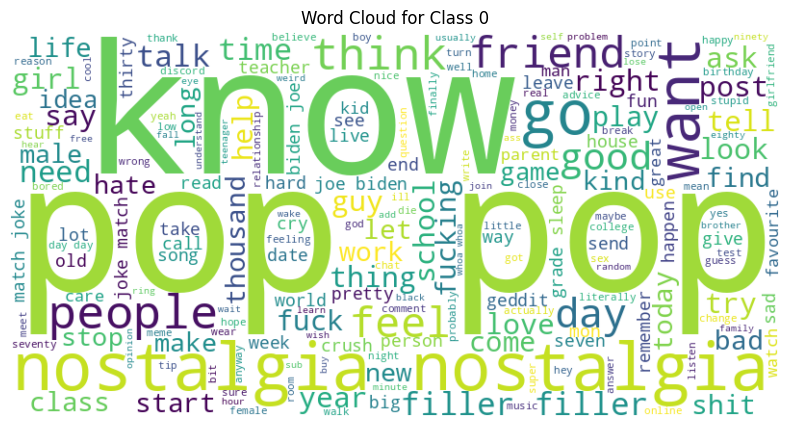

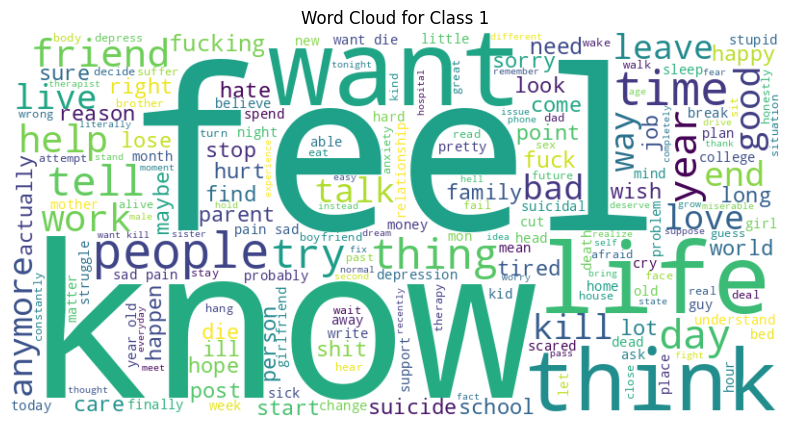

In [143]:
# Create WordCloud for Class 0
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(class_0_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.title('Word Cloud for Class 0')
plt.axis('off')
plt.show()

# Create WordCloud for Class 1
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(class_1_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.title('Word Cloud for Class 1')
plt.axis('off')
plt.show()

## Vectorization

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [114]:
df['class'].replace({'non-suicide': 0, 'suicide': 1},inplace=True)

In [116]:
labels = df['class']

In [117]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectorizer.fit(df['prep_txt'])
X = tfidf_vectorizer.transform(df['prep_txt'])
X_test = tfidf_vectorizer.transform(df['prep_txt'])

X_train, X_val, y_train, y_val = train_test_split(
    X, labels, train_size = 0.75
)

In [118]:
lr = LogisticRegression(C=0.5)
lr.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LogisticRegression(C=0.5)

In [119]:
print ("Accuracy ", accuracy_score(y_val, lr.predict(X_val)))

Accuracy  0.8316062176165803


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [144]:
# Custom text data
custom_text = ["i think i am the lonelyest guy"]

# Vectorize the custom text using the same TF-IDF vectorizer
custom_text_vectorized = tfidf_vectorizer.transform(custom_text)

# Make predictions
predictions = lr.predict(custom_text_vectorized)
if predictions == 0:
    print("non-suicidal")
else:
    print("suicidal")

suicidal


In [67]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [75]:
# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['prep_txt'].tolist(), df['class'].tolist(), test_size=0.2, random_state=42)

In [76]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
# Tokenize and format the data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

In [78]:
# Create DataLoader for training and validation sets
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_fn = loss_fn.to(device)

In [122]:
num_epochs = 3
device

device(type='cuda')

In [83]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (Validation)'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / len(val_dataset)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Accuracy: {accuracy:.4f}')

Epoch 1/3 (Validation): 100%|██████████| 155/155 [00:10<00:00, 15.39it/s]


Epoch 1/3
Training Loss: 0.4187 | Validation Loss: 0.3095 | Accuracy: 0.8673


Epoch 2/3 (Validation): 100%|██████████| 155/155 [00:09<00:00, 15.53it/s]


Epoch 2/3
Training Loss: 0.2178 | Validation Loss: 0.2400 | Accuracy: 0.9223


Epoch 3/3 (Validation): 100%|██████████| 155/155 [00:10<00:00, 15.49it/s]

Epoch 3/3
Training Loss: 0.1259 | Validation Loss: 0.2815 | Accuracy: 0.9094


In [100]:
df.iloc[0][1]

/tmp/ipykernel_42/2309508539.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[0][1]


"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."

In [107]:
custom_text = '''
Ex-wife Making Suicide ThreatsMy wife betrayed me twice and lied to me so much that I decided not to trust her again, thus I recently chose to end our marriage. Just a few days ago, she started making suicide threats. She continues to hesitate because she wants to think that I will return, despite my best efforts over the past few days to talk her out of it. I am aware that many will use this as a means of coercion, but what would happen if she actually did? How am I meant to accept her passing on my hands and what should I do? I still adore my wife, but I can't stand being betrayed once more and having insecurity all the time.
'''

In [108]:
custom_text = remove_punct(custom_text)
custom_text = expand_contraction(custom_text)
custom_text = custom_text.lower()
custom_text = ' '.join([inflector.number_to_words(i[0:25]) if i.isdigit() else i for i in custom_text.split()])
custom_text = spellchecker(custom_text)
custom_text = process_text(custom_text)
custom_text

'wife make suicide threat wife betray twice lie decide trust recently choose end marriage day ago start make suicide threat continue hesitate want think return despite good effort \ufeffthe past day talk aware use means coercion happen actually mean accept pass hand adore wife stand betray have insecurity \ufeffthe time'

In [109]:

input_ids = tokenizer.encode(custom_text, truncation=True, padding=True, return_tensors='pt')
input_ids = input_ids.to(device)
with torch.no_grad():
    model.eval()
    outputs = model(input_ids)
    logits = outputs.logits

# Get predicted class probabilities or labels
probabilities = torch.softmax(logits, dim=1).tolist()[0]
predicted_class = torch.argmax(logits, dim=1).item()

print("Predicted Class Probabilities:", probabilities)
print("Predicted Class:", predicted_class)

Predicted Class Probabilities: [0.004806200508028269, 0.9951937794685364]
Predicted Class: 1


In [ ]:
# Save the fine-tuned model
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')